In [3]:
from sympy import symbols, MatrixSymbol, Matrix, Identity, eye, sin, cos
import sympy as smp
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import dblquad, tplquad, odeint
import plotly.graph_objects as go
from math import comb

Particle at $\vec{r}$ is at a distance $r$ from the rotation axis $\hat{n}$

\begin{align*}
    mr^2 &= m|\vec{r}-(\vec{r}\cdot\hat{n})\hat{n}|^2 \\
      &= m(\vec{r}-(\vec{r}\cdot\hat{n})\hat{n})\cdot(\vec{r}-(\vec{r}\cdot\hat{n})\hat{n})\\
      &= m(r^2 - 2(\vec{r}\cdot\hat{n})(\vec{r}\cdot\hat{n}) + (\vec{r}\cdot\hat{n})^2\hat{n}^2)\\
      &= m(r^2 - (\vec{r}\cdot\hat{n})^2)\\
      &= m(\vec{r}^T\vec{r} - (\vec{r}^T\hat{n})^2)\\
      &= m(\vec{r}^T\vec{r} - \hat{n}^T\vec{r}\vec{r}^T\hat{n})\\
      &= m\hat{n}^T(\vec{r}^T\vec{r}\mathbf{I}_3 - \vec{r}\vec{r}^T)\hat{n}\\
\end{align*}

Now we will call the matrix in the middle $I$ so $mr^2 = \hat{n}^T I\hat{n}$

We know that $\omega\hat{n} = \vec{\omega}$, so 
\begin{align*}
T_{\textrm{rotational}} &= \frac{1}{2}mr^2\omega^2\\
  &= \frac{1}{2}\hat{n}^T I\hat{n}\omega^2\\
  &= \frac{1}{2}\vec{\omega}^TI\vec{\omega}
\end{align*}

In [110]:
x, y, z = symbols('x y z')
v = Matrix([x,y,z])
I3 = eye(3)
I = v.T.dot(v) * I3 - v * v.T
I

Matrix([
[y**2 + z**2,        -x*y,        -x*z],
[       -x*y, x**2 + z**2,        -y*z],
[       -x*z,        -y*z, x**2 + y**2]])

Angular displacements (vectors) are ordered, represented as matrices because they doesn't commute.

Angular velocities (vectors) can be added upon each other.

Using euler's angles we have

$$
\vec{\omega} = \dot\phi\hat{z} + T_1(\dot\theta\hat{x} + T_2(\dot\psi\hat{z}))
$$
<p align="right">
<img src="./euler angles.png" alt="euler angles" width="300" />
<p>

In [112]:
t, h, g = smp.symbols('t h g', real=True)
the, phi, psi = smp.symbols(r'\theta \phi \psi', cls=smp.Function)
the = the(t)
the_d = the.diff(t)
the_dd = the_d.diff(t)
phi = phi(t)
phi_d = phi.diff(t)
phi_dd = phi_d.diff(t)
psi = psi(t)
psi_d = psi.diff(t)
psi_dd = psi_d.diff(t)

In [101]:
R1 = smp.matrices.dense.rot_givens(0,1,-phi)
R2 = smp.matrices.dense.rot_givens(1,2,-the)
R3 = smp.matrices.dense.rot_givens(0,1,-psi)

In [102]:
omega = Matrix([0,0,phi_d]) + R1 * (Matrix([the_d,0,0]) + R2 * Matrix([0,0,psi_d]))

In [103]:
omega

Matrix([
[sin(\phi(t))*sin(\theta(t))*Derivative(\psi(t), t) + cos(\phi(t))*Derivative(\theta(t), t)],
[sin(\phi(t))*Derivative(\theta(t), t) - sin(\theta(t))*cos(\phi(t))*Derivative(\psi(t), t)],
[                            cos(\theta(t))*Derivative(\psi(t), t) + Derivative(\phi(t), t)]])

Bezier curves

C:\Users\张索\AppData\Local\Temp\ipykernel_13936\2899050399.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Bx = np.sum(comb(n,i)*(1-t)**(n-i)*t**i*Px[i] for i in range(n+1))
C:\Users\张索\AppData\Local\Temp\ipykernel_13936\2899050399.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  By = np.sum(comb(n,i)*(1-t)**(n-i)*t**i*Py[i] for i in range(n+1))


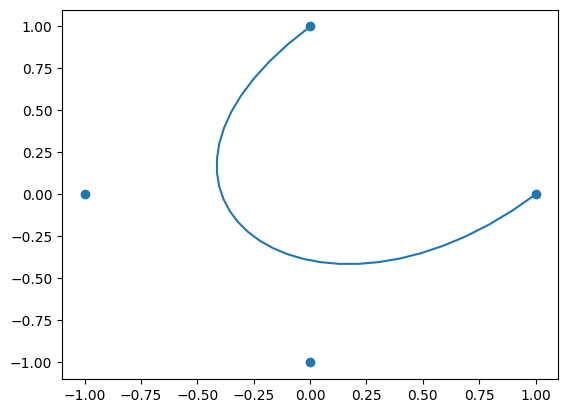

In [89]:
t = np.linspace(0,1,30)
# 2D bezier curve
Px = np.array([0,-1,0,1])
Py = np.array([1,0,-1,0])
n = len(Px)-1
Bx = np.sum(comb(n,i)*(1-t)**(n-i)*t**i*Px[i] for i in range(n+1))
By = np.sum(comb(n,i)*(1-t)**(n-i)*t**i*Py[i] for i in range(n+1))
plt.plot(Bx,By)
plt.scatter(Px,Py)

Composite Bezier curve / Bezier spline

--- a series of 3nd order Bezier curves joined together

In [81]:
def CBezier(Px, Py, Pz=None, resolution=30):
    three_D = False
    n = Px.size
    if (n-1) % 3 != 0:
        raise Exception('composite curve have %d points defined'%n)
    elif n != Py.size:
        raise Exception('size of Px (%d) and Py (%d) are not equal'%(n,Py.size))
    elif Pz != None:
        three_D = True
        if n != Pz.size:
            raise Exception('size of Px (%d) and Pz (%d) are not equal'%(n,Pz.size))
    n = (n-1)//3
    t = np.linspace(0,1,30)
    Bx = np.empty(resolution * n)
    By = np.empty(resolution * n)
    if three_D:
        Bz = np.empty(resolution * n)
    for j in range(0,n):
        Bx[30*j:30*j+30] = sum(comb(3,i)*(1-t)**(3-i)*t**i*Px[3*j+i] for i in range(4))
        By[30*j:30*j+30] = sum(comb(3,i)*(1-t)**(3-i)*t**i*Py[3*j+i] for i in range(4))
        if three_D:
            Bz[30*j:30*j+30] = sum(comb(3,i)*(1-t)**(3-i)*t**i*Pz[3*j+i] for i in range(4))
    if three_D:
        return Bx, By, Bz
    else:
        return Bx, By
    
def draw2DBezierCurve(px, py, resolution=30, linecolor='blue', handlecolor='red'):
    pointsx = Px[0::3]
    pointsy = Py[0::3]
    hlx = Px[2::3]
    hly = Py[2::3]
    hrx = Px[1::3]
    hry = Py[1::3]
    
    plt.gca().set_aspect((plt.xlim()[1]-plt.xlim()[0])/(plt.ylim()[1]-plt.ylim()[0]))
    for i in range(len(hlx)):
        plt.plot([hlx[i],pointsx[i+1]],[hly[i],pointsy[i+1]],c=handlecolor)
        plt.plot([hrx[i],pointsx[i]],[hry[i],pointsy[i]],c=handlecolor)

    plt.scatter(hlx,hly,c=handlecolor)
    plt.scatter(hrx,hry,c=handlecolor)
    
    Bx, By = CBezier(px,py, resolution=resolution)
    plt.plot(Bx,By,c=linecolor)
    plt.scatter(pointsx,pointsy,c=linecolor)

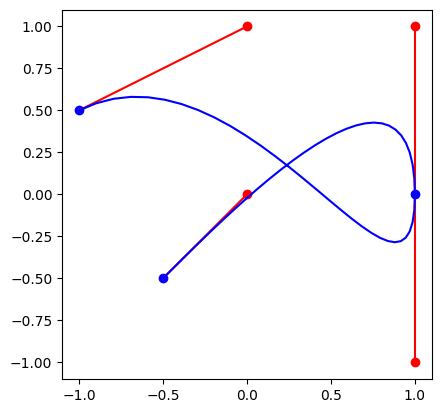

In [82]:
Px = np.array([-1, 0,1,1, 1,0,-0.5])
Py = np.array([0.5, 1,-1,0, 1,0,-0.5])
draw2DBezierCurve(Px, Py)

In [28]:
def readBezierCurve(filepath, encoding='utf-8'): # read from UE style CSV, 
    with open(filepath, 'r', encoding=encoding) as f:
        l = f.readlines()
        l.pop(0)
        j = len(l)
        px = np.empty(3*j-2)
        py = np.empty(3*j-2)
        pz = np.empty(3*j-2)
        for i in range(j):
            l[i] = l[i].split(',')
        for i in range(j):
            if i!=0 and i!=j-1:
                px[3*i-1] = float(l[i][4])
                py[3*i-1] = float(l[i][5])
                pz[3*i-1] = float(l[i][6])
                px[3*i] = float(l[i][1])
                py[3*i] = float(l[i][2])
                pz[3*i] = float(l[i][3])
                px[1+3*i] = float(l[i][7])
                py[1+3*i] = float(l[i][8])
                pz[1+3*i] = float(l[i][9])
            elif i==0:
                px[0] = float(l[0][1])
                py[0] = float(l[0][2])
                pz[0] = float(l[0][3])
                px[1] = float(l[0][7])
                py[1] = float(l[0][8])
                pz[1] = float(l[0][9])
            else:
                px[-2] = float(l[-1][4])
                py[-2] = float(l[-1][5])
                pz[-2] = float(l[-1][6])
                px[-1] = float(l[-1][1])
                py[-1] = float(l[-1][2])
                pz[-1] = float(l[-1][3])
    return px, py, pz

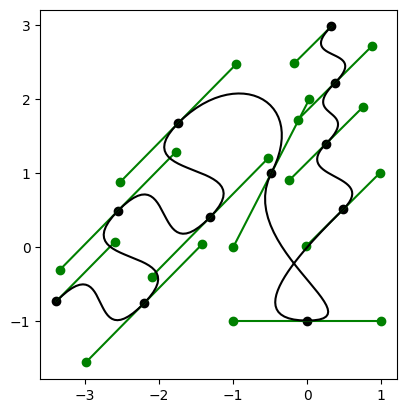

In [84]:
Px, Py, Pz = readBezierCurve('./curve1.csv')
draw2DBezierCurve(Px, Py,linecolor='black',handlecolor='green')

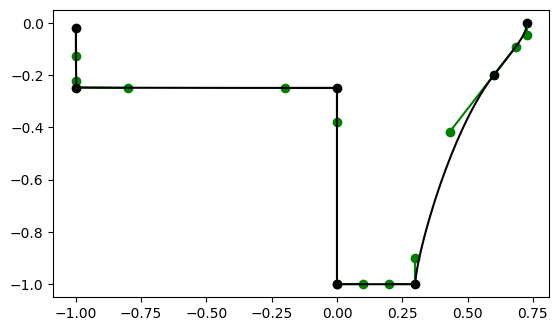

In [85]:
Px, Py, Pz = readBezierCurve('./curve2.csv')
draw2DBezierCurve(Px, Py,linecolor='black',handlecolor='green')

In [93]:
# revolves around x; y and z are the same

Ixx = sum(Py**2)/2
Izz = sum(Py**2)/4 + sum(Px**2)/3

I = Matrix([[Ixx, 0, 0],
            [0, Izz, 0],
            [0, 0, Izz]])

I

Matrix([
[3.244633344628,              0,              0],
[             0, 3.945732252527,              0],
[             0,              0, 3.945732252527]])

In [95]:
h = sum(Px)/len(Px)

In [130]:
Ixx, Iyy, Izz, Ixy, Ixz, Iyz = symbols(r'I_{xx}, I_{yy}, I_{zz}, I_{xy}, I_{xz}, I_{yz}')

I = Matrix([[Ixx, Ixy, Ixz],
            [Ixy, Iyy, Iyz],
            [Ixz, Iyz, Izz]])

In [137]:
# m = 1
g = 9.81
T = omega.T.dot((I*omega))/2
V = g*smp.cos(the)
L = T-V

In [132]:
LE1 = L.diff(the) - L.diff(the_d).diff(t)
LE2 = L.diff(phi) - L.diff(phi_d).diff(t)
LE3 = L.diff(psi) - L.diff(psi_d).diff(t)

LE1.simplify()
LE2.simplify()
LE3.simplify()

-x**2*sin(2*\phi(t) - 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/4 + x**2*sin(2*\phi(t) - 2*\theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t)/4 - x**2*sin(2*\phi(t) - \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/2 + x**2*sin(2*\phi(t) - \theta(t))*Derivative(\theta(t), t)**2/4 + x**2*sin(2*\phi(t) + \theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t)/2 + x**2*sin(2*\phi(t) + \theta(t))*Derivative(\theta(t), t)**2/4 - x**2*sin(2*\phi(t) + 2*\theta(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/4 - x**2*sin(2*\phi(t) + 2*\theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t)/4 + x**2*sin(2*\phi(t))*Derivative(\phi(t), t)*Derivative(\psi(t), t)/2 + x**2*sin(\theta(t))*Derivative(\phi(t), t)*Derivative(\theta(t), t) + x**2*sin(2*\theta(t))*Derivative(\psi(t), t)*Derivative(\theta(t), t)/2 + x**2*cos(2*\phi(t) - 2*\theta(t))*Derivative(\psi(t), (t, 2))/8 + x**2*cos(2*\phi(t) - \theta(t))*Derivative(\theta(t), (t, 2))/4 - x**2*cos(2*\phi(t

In [144]:
sols = smp.solve((LE1,LE2,LE3),(the_dd, phi_dd, psi_dd))

In [119]:
dz1dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[the_dd])
dthedt_f = smp.lambdify(the_d, the_d)

dz2dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)

dz3dt_f = smp.lambdify((g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,the_d,phi_d,psi_d), sols[psi_dd])
dpsidt_f = smp.lambdify(psi_d, psi_d)

NameError: name 'Iyy' is not defined

In [118]:
def dSdt(S, t):
    the, z1, phi, z2, psi, z3 = S
    return [
        dthedt_f(z1),
        dz1dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
        dphidt_f(z2),
        dz2dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
        dpsidt_f(z3),
        dz3dt_f(g, h, Ixx,Iyy,Izz,Ixy,Iyz,Ixz,the,phi,psi,z1,z2,z3),
    ]

In [ ]:
t = np.linspace(0, 2, 10000)
# Initial Condition 1
ans = odeint(dSdt, y0=[np.pi/4, 0, 0, 10, 0, 2*np.pi*60], t=t)

In [ ]:
the_t = ans.T[0]
phi_t = ans.T[2]
psi_t = ans.T[4]
plt.plot(t,the_t)